# Comparing Scores for tigge, deterministic, parametric, test-time dropout, categorical models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *
from src.score import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
#if model was trained on mixed precision policy, loading on the same policy necessary? Yes. see verbose results of model.predict
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [5]:
model_save_dir='/home/garg/data/WeatherBench/predictions_P/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions_P'
# model_save_dir='/home/rasp/data/myWeatherBench/predictions_P/saved_models/'
# datadir='/data/stephan/WeatherBench/5.625deg/'
# pred_save_dir='/home/rasp/data/myWeatherBench/predictions_P/'

#choose 3 day or 5 day
result_dir='/home/garg/data/WeatherBench/tmp' #3day
result_dir='/home/garg/data/WeatherBench/tmp/5_day' #5day


In [6]:
#Parameters
lead_time=72 #3days
lead_time=120 #5days
members=50

In [7]:
!ls $pred_save_dir

001-resnet_d3_ztt_3d_dr0.0.nc	   010-resnet_d3_z_3d_cat_quant.nc
001-resnet_d3_ztt_3d_dr0.0_m3.nc   011-resnet_d3_t_3d_cat_quant.nc
001-resnet_d3_ztt_3d_dr0.0_m50.nc  012-resnet_d3_t2m_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	   013-resnet_d3_tp_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m2.nc   017-resnet_d3_ztt_3d_m50.nc
003-resnet_d3_ztt_3d_dr0.2_m50.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5.nc	   020-resnet_d3_tp_3d_dr0.0_m50.nc
004-resnet_d3_ztt_3d_dr0.5_m2.nc   021-resnet_d3_tp_3d_dr0.2.nc
004-resnet_d3_ztt_3d_dr0.5_m5.nc   021-resnet_d3_tp_3d_dr0.2_m2.nc
004-resnet_d3_ztt_3d_dr0.5_m50.nc  021-resnet_d3_tp_3d_dr0.2_m50.nc
005-resnet_d3_ztt_3d_param.nc	   022-resnet_d3_tp_3d_dr0.5.nc
005.1-resnet_d3_ztt_3d_param.nc    022-resnet_d3_tp_3d_dr0.5_m5.nc
006-resnet_d3_z_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m50.nc
006.1-resnet_d3_z_3d_cat.nc	   028-resnet_d3_z_5d_cat.nc
007-resnet_d3_t_3d_cat.nc	   029-resnet_d3_t_5d_cat.nc
007.1-resnet_d3_t_3d_cat.nc	   030-res

## Data

In [30]:
!ls {datadir}

2017_2018_subset.zip	  geopotential	     toa_incident_solar_radiation
2m_temperature		  geopotential_500   u_component_of_wind
6hr_precipitation	  specific_humidity  v_component_of_wind
backup_specific_humidity  temperature
constants		  temperature_850


In [31]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}/2m_temperature/*.nc',combine='by_coords')
tp_valid=xr.open_mfdataset(f'{datadir}/6hr_precipitation/*.nc',combine='by_coords')

# SR: Not necessary because we never look at other levels
ztt_valid=xr.merge([z500_valid,t850_valid, t2m_valid])  #.rename({'z':'z_500', 't':'t_850'})
valid=xr.merge([ztt_valid, tp_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

## TIGGE

In [32]:
#tigge_dir = '/mnt/netdisk1/stephan/WeatherBench/tigge/5.625deg/'
tigge_dir = '/home/garg/data/WeatherBench/tigge/5.625deg/'

In [33]:
!ls $tigge_dir

2m_temperature	geopotential_500_ens  temperature_850_ens  total_precipitation


In [34]:
tigge_z = xr.open_mfdataset(f'{tigge_dir}geopotential_500_ens/*nc')
tigge_t = xr.open_mfdataset(f'{tigge_dir}temperature_850_ens/*nc')
#tigge_t2m = xr.open_mfdataset(f'{tigge_dir}2m_temperature_ens/*nc')
tigge_t2m = xr.open_mfdataset(f'{tigge_dir}2m_temperature/*nc')
# tigge_tp = xr.open_mfdataset(f'{tigge_dir}total_precipitation_ens/*nc')
tigge_tp = xr.open_mfdataset(f'{tigge_dir}total_precipitation/*nc')



/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/garg/miniconda3/envs/weather

In [35]:
# Covert to ERA convention
tigge_z *= 9.806

In [36]:
tigge_tp = tigge_tp.diff('step') / 1000.

In [37]:
tigge = xr.merge([tigge_z, tigge_t, tigge_t2m, tigge_tp], compat="override")

In [38]:
tigge = tigge.rename({'number': 'member', 'gh':'z'})

#tigge = tigge.sel(step='3 days') #3days
tigge = tigge.sel(step='5 days') #5days
tigge['time'] = tigge['valid_time']

In [39]:
tigge = tigge.sel(time=slice('2017', '2018'))

In [40]:
tigge.load()

<xarray.Dataset>
Dimensions:            (lat: 32, lon: 64, member: 50, time: 1450)
Coordinates:
    step               timedelta64[ns] 5 days
  * time               (time) datetime64[ns] 2017-01-06 ... 2018-12-31T12:00:00
    isobaricInhPa      int64 500
    valid_time         (time) datetime64[ns] 2017-01-06 ... 2018-12-31T12:00:00
  * lat                (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon                (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * member             (member) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    heightAboveGround  int64 2
    surface            int64 0
Data variables:
    z                  (member, time, lat, lon) float32 50642.984 ... 48422.85
    t                  (member, time, lat, lon) float32 258.7309 ... 247.46666
    t2m                (member, time, lat, lon) float32 247.7549 ... 245.17899
    tp                 (member, time, lat, lon) float32 nan ... 0.00031967115

### RMSE of ensemble mean

In [41]:
tigge_rmse = compute_weighted_rmse(tigge.mean('member'), valid).load()

/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [42]:
tigge_rmse

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
    step               timedelta64[ns] 5 days
    surface            int64 0
Data variables:
    z                  float64 296.8
    t                  float64 1.725
    t2m                float64 1.567
    tp                 float64 0.004688

In [46]:
#tigge_rmse.to_netcdf('../../data/WeatherBench/tmp/5_day/tigge_rmse.nc')

### Spread-skill

In [47]:
tigge_spreadskill=compute_weighted_meanspread(tigge)/tigge_rmse
tigge_spreadskill

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 5 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
    surface            int64 0
Data variables:
    z                  float64 1.001
    t                  float64 0.957
    t2m                float64 0.7981
    tp                 float64 0.9749

In [48]:
#tigge_spreadskill.to_netcdf('../../data/WeatherBench/tmp/5_day/tigge_spreadskill.nc')

### CRPS

In [49]:
tigge_crps=compute_weighted_crps(tigge, valid.sel(time=tigge.time))
tigge_crps.load()

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 5 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
    surface            int64 0
Data variables:
    z                  float64 126.8
    t                  float64 0.8338
    t2m                float64 0.6979
    tp                 float64 0.001414

In [50]:
#tigge_crps.to_netcdf('../../data/WeatherBench/tmp/5_day/tigge_crps.nc')

### Global Maps

In [18]:
def rmse_global(da_fc, da_true):
    error = da_fc - da_true
    weights_lat = np.cos(np.deg2rad(error.lat))
    weights_lat /= weights_lat.mean()
    rmse = np.sqrt(((error)**2 * weights_lat).mean('time'))
    return rmse

tigge_global_rmse=rmse_global(tigge.mean('member'), valid)

/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
def spread_global(da_fc):
    var1=da_fc.var('member')
    weights_lat = np.cos(np.deg2rad(var1.lat))
    weights_lat /= weights_lat.mean()
    mean_spread= np.sqrt((var1*weights_lat).mean('time'))
    return mean_spread

tigge_global_ss=spread_global(tigge)/tigge_global_rmse

In [20]:
def crps_global(da_fc, da_true):
    da_true=da_true.sel(time=da_fc.time)
    assert (da_true.time==da_fc.time).all #checking size.
    
    weights_lat = np.cos(np.deg2rad(da_fc.lat))
    weights_lat /= weights_lat.mean()
    crps = xs.crps_ensemble(da_true, da_fc)
    crps = (crps * weights_lat).mean('time')
    return crps

tigge_global_crps=crps_global(tigge, valid.sel(time=tigge.time))

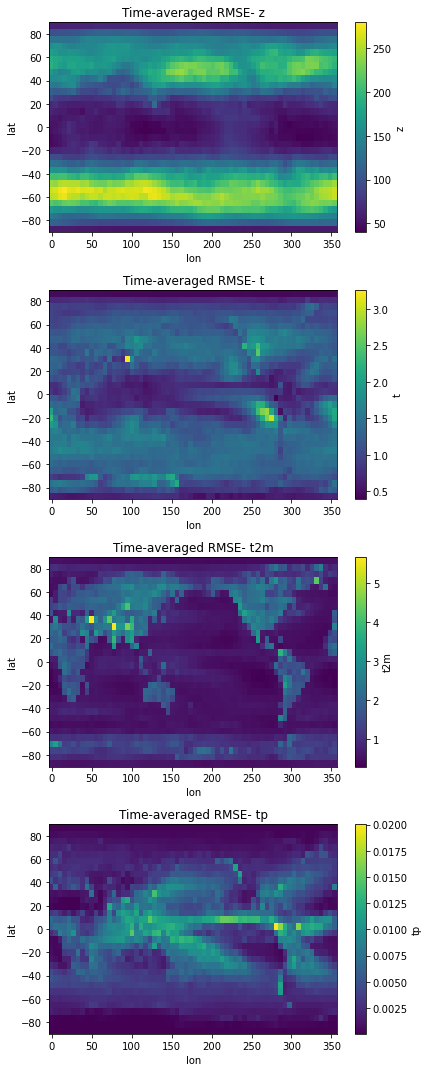

In [23]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    tigge_global_rmse[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged RMSE- {v}')
    plt.savefig(f'{result_dir}/figures/tigge_global_rmse_{v}.pdf')
fig.tight_layout()

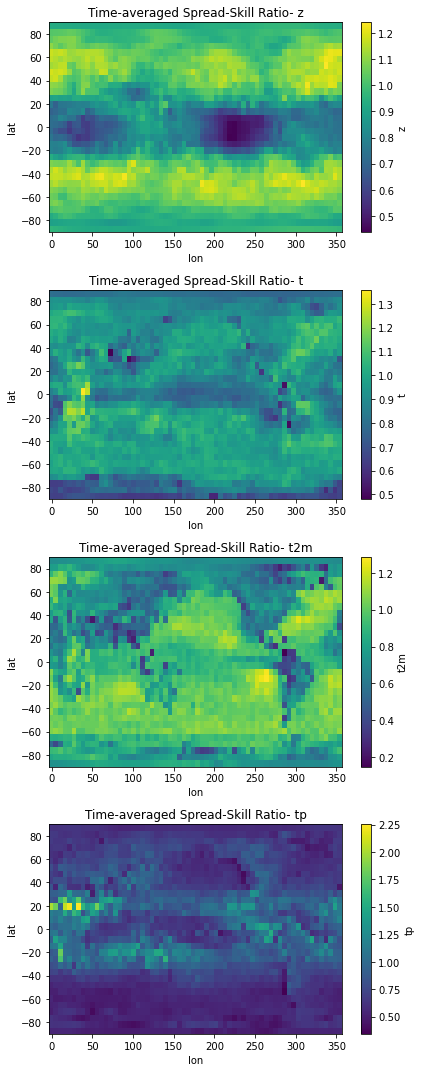

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    tigge_global_ss[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged Spread-Skill Ratio- {v}')
    plt.savefig(f'{result_dir}/figures/tigge_global_ss_{v}.pdf')
    
fig.tight_layout()

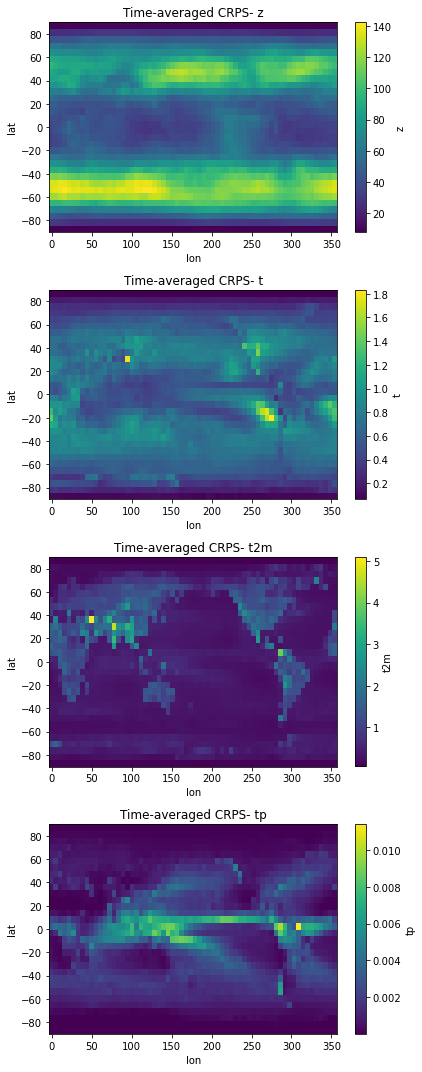

In [25]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    tigge_global_crps[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged CRPS- {v}')
    plt.savefig(f'{result_dir}/figures/tigge_global_crps_{v}.pdf')
fig.tight_layout()

### Rank histogram

In [51]:
from ranky import rankz
from scipy.stats import rankdata
import pdb

def rankz_weighted(obs, ensemble, weights_lat, density=False):
    shape = obs.shape
    obs = obs.reshape(-1)
    ensemble = ensemble.reshape(ensemble.shape[0], -1)
    
    combined=np.vstack((obs[np.newaxis],ensemble))
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)
    
    #ToDo: not sure if this ties-part works for ndarray. but minor thing.
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    has_tie = np.argwhere(ties > 0).squeeze()

    for i in has_tie:
#         print('Tie', ranks[i], ensemble[:, i], obs[i])
        min_rank = ranks[i]
        max_rank = ranks[i] + ties[i]
        ranks[i] = np.random.randint(min_rank, max_rank)
    
    ranks = ranks.reshape(shape)
    
    weights=np.ones(ranks.shape)
    weights=weights*weights_lat[np.newaxis,:,np.newaxis]

    return np.histogram(ranks, bins=np.linspace(0.5, combined.shape[0]+0.5, combined.shape[0]+1),
                       weights=weights, density=density)

In [52]:
weights_lat = np.cos(np.deg2rad(valid.lat))
weights_lat /= weights_lat.mean()

In [53]:
ranks = {}
for v in tigge:
    print(v)
    time = tigge.time
    p = tigge[v].sel(time=time)
    o = valid[v].sel(time=time).load()
    
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)

    ranks[v] = rank

z


KeyboardInterrupt: 

In [36]:
with open(f'tmp/tigge_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

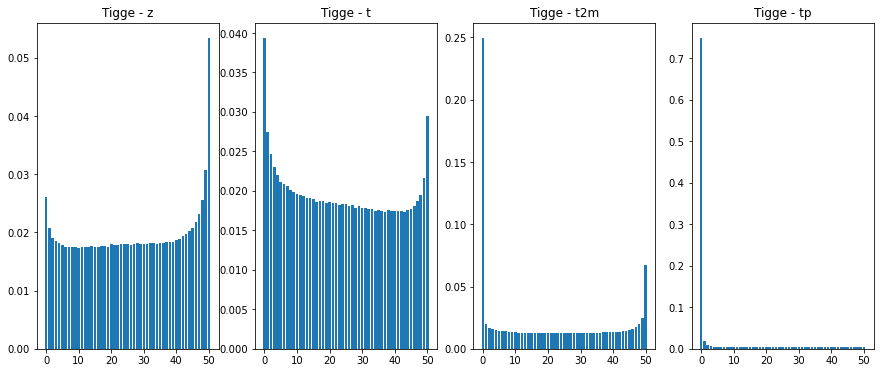

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Tigge - {v}')

Uncalibrated, probably simple bias.

## Monte-carlo dropout

In [26]:
#pred_save_dir_dr='/home/rasp/data/myWeatherBench/predictions_'
pred_save_dir_dr='/home/garg/data/WeatherBench/predictions_'

mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'C/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'C/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

### Load and evaluate no-dropout predictions

In [86]:
rmses, maes = [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i]+'.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i]+'.nc')
    preds = xr.merge([preds_ztt, preds_tp]).isel(time=slice(0, None, 12))
    rmse = compute_weighted_rmse(preds, valid).load()
    rmses.append(rmse)
    mae = compute_weighted_mae(preds, valid).load()
    maes.append(mae)

4it [00:15,  3.78s/it]


In [87]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
rmses

<xarray.Dataset>
Dimensions:     (concat_dim: 4)
Coordinates:
  * concat_dim  (concat_dim) float64 0.0 0.1 0.2 0.5
Data variables:
    t2m         (concat_dim) float64 1.606 1.528 1.598 1.866
    z           (concat_dim) float64 351.5 313.7 323.0 376.2
    t           (concat_dim) float64 1.931 1.793 1.854 2.109
    tp          (concat_dim) float64 0.002278 0.002216 0.002217 0.002259

In [ ]:
#rmses.to_netcdf('tmp/dropout_det_rmse.nc')
#maes.to_netcdf('tmp/dropout_det_mae.nc')

In [10]:
rmses = xr.open_dataset('tmp/dropout_det_rmse.nc')

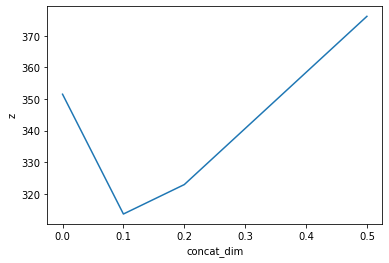

In [11]:
rmses.z.plot();

### Create 50 member dropout predictions

SR: Only predicting every 12th time step. Makes very little difference for score and is 12 times faster. You should be able to do this on PC as well. For me this takes around 4 minutes.

Note: Manually change P to C for 0.1 exps.

In [52]:
ss = ''
for e in mc_exp_ids_ztt:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && '
#     print(s)
    ss += s
print(ss)

python create_dropout_ensemble.py  50  ../nn_configs/P/001-resnet_d3_ztt_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/C/017-resnet_d3_ztt_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/003-resnet_d3_ztt_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBenc

In [54]:
ss = ''
for e in mc_exp_ids_tp:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && '
#     print(s)
    ss += s
print(ss)

python create_dropout_ensemble.py  50  ../nn_configs/P/020-resnet_d3_tp_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/C/054-resnet_d3_tp_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/021-resnet_d3_tp_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/022-resnet_d3_tp_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/pr

### Compute RMSE of ensemble mean and spread/skill and CRPS

In [27]:
members = 50

In [28]:
mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'P/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'P/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

In [ ]:
rmses, maes, crpss, spread_skills = [], [], [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    ens_mean = preds.mean('member')
    rmse = compute_weighted_rmse(ens_mean, valid).load()
    mae = compute_weighted_mae(ens_mean, valid).load()
    crps = compute_weighted_crps(preds, valid).load()
    spread = compute_weighted_meanspread(preds).load()
    rmses.append(rmse)
    maes.append(mae)
    crpss.append(crps)
    spread_skills.append(spread / rmse)

0it [00:00, ?it/s]

In [58]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
crpss = xr.concat(crpss, dim=[0, 0.1, 0.2, 0.5])
spread_skills = xr.concat(spread_skills, dim=[0, 0.1, 0.2, 0.5])

In [59]:
# rmses.to_netcdf('tmp/dropout_rmse.nc')
# maes.to_netcdf('tmp/dropout_mae.nc')
# crpss.to_netcdf('tmp/dropout_crps.nc')
# spread_skills.to_netcdf('tmp/dropout_spreadskill.nc')

In [60]:
rmses = xr.open_dataset('tmp/dropout_rmse.nc')
maes = xr.open_dataset('tmp/dropout_mae.nc')
crpss = xr.open_dataset('tmp/dropout_crps.nc')
spread_skills = xr.open_dataset('tmp/dropout_spreadskill.nc')

In [64]:
rmses_det = xr.open_dataset('tmp/dropout_det_rmse.nc')

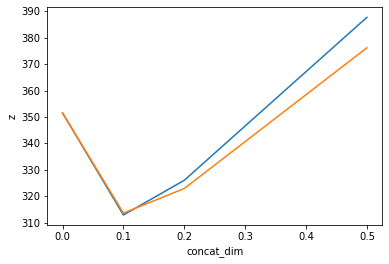

In [65]:
rmses.z.plot();
rmses_det.z.plot();

In [62]:
crpss[['z', 't', 't2m', 'tp']].isel(concat_dim=3).load()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    concat_dim  float64 0.5
Data variables:
    z           float64 193.7
    t           float64 1.197
    t2m         float64 0.9013
    tp          float64 0.0005988

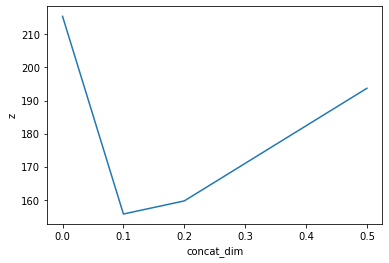

In [63]:
crpss.z.plot()

### Global Maps

In [29]:
    rmses, crpss, spread_skills = [], [], []
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[1]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[1]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
#     ens_mean = preds.mean('member')
#     rmse = compute_weighted_rmse(ens_mean, valid).load()
#     #mae = compute_weighted_mae(ens_mean, valid).load()
#     crps = compute_weighted_crps(preds, valid).load()
#     spread = compute_weighted_meanspread(preds).load()
#     rmses.append(rmse)
#     #maes.append(mae)
#     crpss.append(crps)
#     spread_skills.append(spread / rmse)

In [31]:
    ens_mean = preds.mean('member')
    rmse = compute_weighted_rmse(ens_mean, valid).load()

In [15]:
spread = compute_weighted_meanspread(preds).load()
spread_skill=(spread / rmse)

In [ ]:
crps = compute_weighted_crps(preds, valid).load()

In [32]:
def rmse_global(da_fc, da_true):
    error = da_fc - da_true
    weights_lat = np.cos(np.deg2rad(error.lat))
    weights_lat /= weights_lat.mean()
    rmse = np.sqrt(((error)**2 * weights_lat).mean('time'))
    return rmse

mc_global_rmse=rmse_global(ens_mean, valid)

def spread_global(da_fc):
    var1=da_fc.var('member')
    weights_lat = np.cos(np.deg2rad(var1.lat))
    weights_lat /= weights_lat.mean()
    mean_spread= np.sqrt((var1*weights_lat).mean('time'))
    return mean_spread

mc_global_ss=spread_global(preds)/mc_global_rmse

def crps_global(da_fc, da_true):
    da_true=da_true.sel(time=da_fc.time)
    assert (da_true.time==da_fc.time).all #checking size.
    
    weights_lat = np.cos(np.deg2rad(da_fc.lat))
    weights_lat /= weights_lat.mean()
    crps = xs.crps_ensemble(da_true, da_fc)
    crps = (crps * weights_lat).mean('time')
    return crps



In [33]:
valid2=valid.sel(time=slice('2017-01-04T12','2018-12-31T18'))

mc_global_crps=crps_global(preds, valid2.sel(time=preds.time))
#mc_global_crps=crps_global(preds, valid)

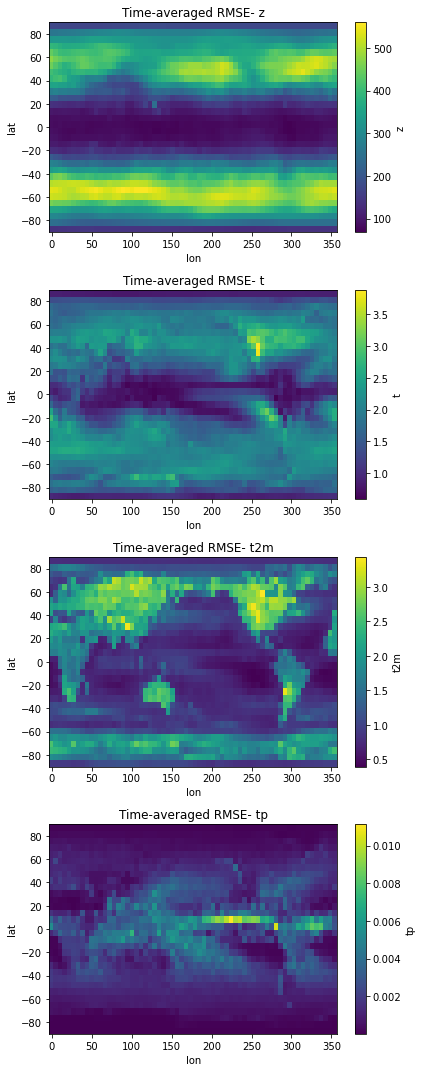

In [34]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    mc_global_rmse[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged RMSE- {v}')
    plt.savefig(f'{result_dir}/figures/mc_global_rmse_{v}.pdf')
fig.tight_layout()

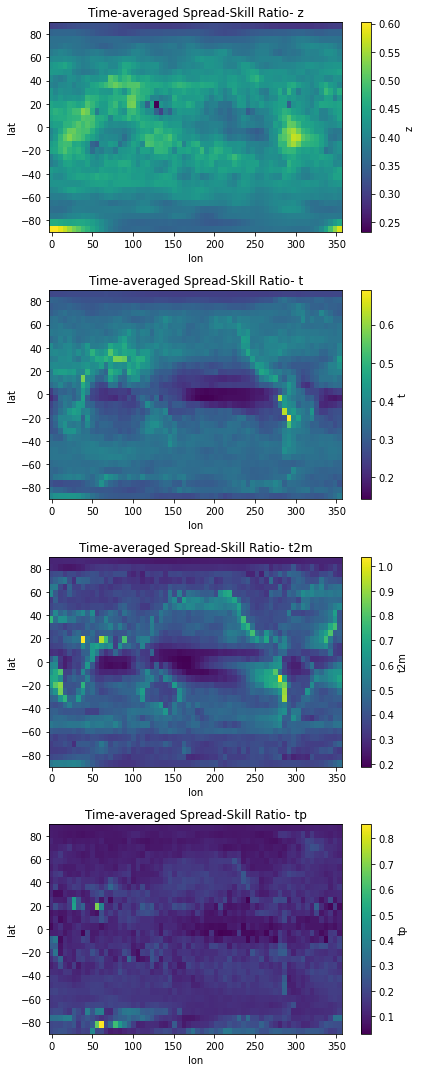

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    mc_global_ss[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged Spread-Skill Ratio- {v}')
    plt.savefig(f'{result_dir}/figures/mc_global_ss_{v}.pdf')
fig.tight_layout()

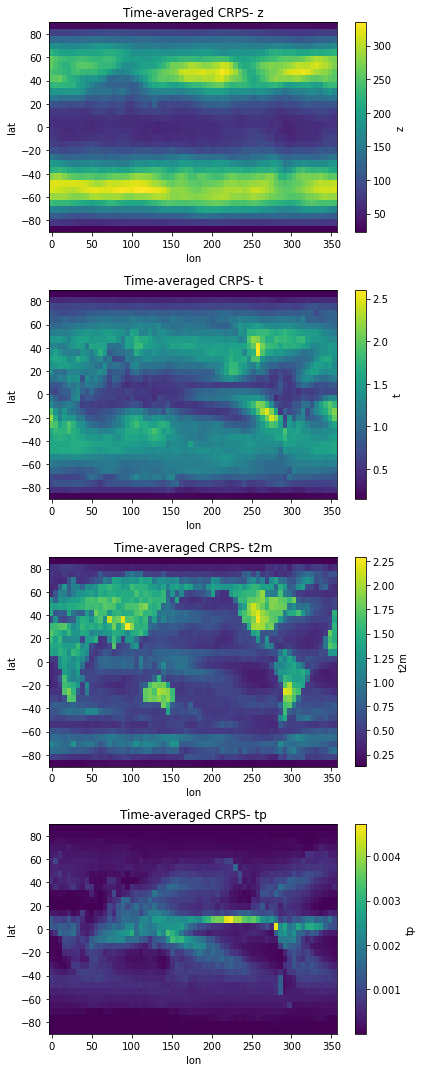

In [36]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    mc_global_crps[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged CRPS- {v}')
    plt.savefig(f'{result_dir}/figures/mc_global_crps_{v}.pdf')
fig.tight_layout()

### Rank histogram

In [69]:
ranks = {}
for i, dr in tqdm(enumerate([0.1, 0.2, 0.5])):
    ranks[dr] = {}
    print(dr)
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i+1]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i+1]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    for v in preds:
        print(v)
        time = preds.time
        p = preds[v].sel(time=time)
        o = valid[v].sel(time=time).load()
        rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
        ranks[dr][v] = rank

0it [00:00, ?it/s]

0.1
t
t2m
z
tp


1it [14:49, 889.18s/it]

0.2
z
t
t2m
tp


2it [29:52, 893.42s/it]

0.5
z
t2m
t
tp


3it [44:57, 899.09s/it]


In [70]:
with open(f'tmp/dropout_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

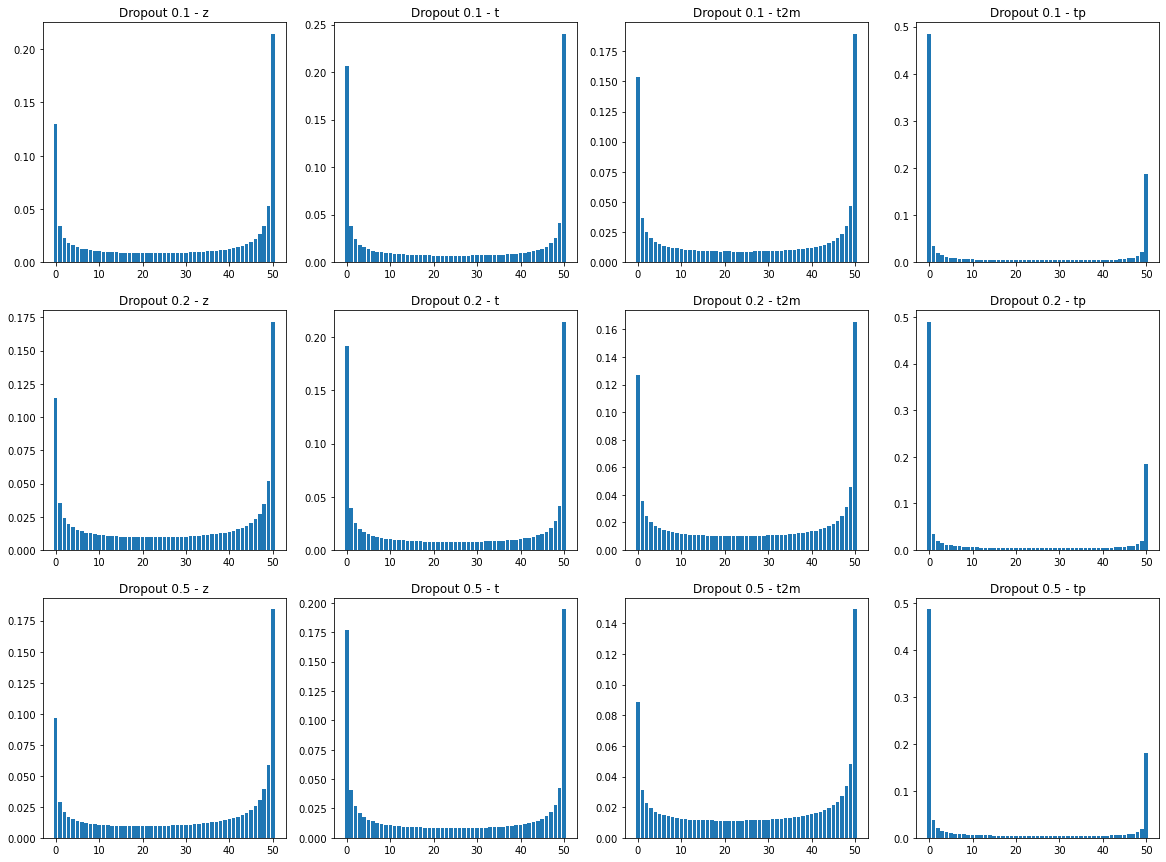

In [71]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, dr in enumerate([0.1, 0.2, 0.5]):
    for j, v in enumerate(['z', 't', 't2m', 'tp']):
        r = ranks[dr][v]
        axs[i, j].bar(np.arange(51), r[0])
        axs[i, j].set_title(f'Dropout {dr} - {v}')

## Parametric - tp missing

In [37]:
preds_ztt = xr.open_dataset(f'{pred_save_dir}/005.1-resnet_d3_ztt_3d_param.nc')

In [38]:
preds_ztt_mean=preds_ztt[['z-mean','t-mean','t2m-mean']].rename({'z-mean':'z','t-mean':'t','t2m-mean':'t2m'})
preds_ztt_std=preds_ztt[['z-std','t-std','t2m-std']].rename({'z-std':'z','t-std':'t','t2m-std':'t2m'})

In [39]:
preds_ztt_std = preds_ztt_std.where(preds_ztt_std>0, 1e-7)  # To avoid division by zero in CRPS

### RMSE of ensemble mean

In [34]:
rmse = compute_weighted_rmse(preds_ztt_mean, valid).compute()
rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 315.3
    t        float64 1.818
    t2m      float64 1.549

In [35]:
#rmse.to_netcdf('tmp/parametric_rmse.nc')

### Spread skill

In [36]:
var = preds_ztt_std**2

In [37]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [38]:
spread= np.sqrt((var*weights_lat).mean())

In [39]:
spread_skill = spread / rmse

In [40]:
spread_skill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 0.8716
    t        float64 0.9208
    t2m      float64 0.9462

In [41]:
#spread_skill.to_netcdf('tmp/parametric_spreadskill.nc')

### CRPS

In [42]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[: , None, None]).mean(mean_dims)
    return crps

In [43]:
crps = compute_weighted_crps_gaussian(valid.isel(time=slice(0, None, 12))[['z', 't', 't2m']], 
                                      preds_ztt_mean, preds_ztt_std).load()
crps

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 142.7
    t        float64 0.9016
    t2m      float64 0.7037

In [ ]:
#crps.to_netcdf('tmp/parametric_crps.nc')

### Global Maps

In [40]:
param_global_rmse=rmse_global(preds_ztt_mean, valid)

In [41]:
var = preds_ztt_std**2
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()
spread_global= np.sqrt((var*weights_lat).mean('time'))
param_global_ss = spread_global / param_global_rmse

In [42]:
def compute_weighted_crps_gaussian_global(obs, mean, std):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[: , None, None]).mean('time')
    return crps

param_global_crps=compute_weighted_crps_gaussian_global(valid.isel(time=slice(0, None, 12))[['z', 't', 't2m']], 
                                                        preds_ztt_mean, preds_ztt_std).load()

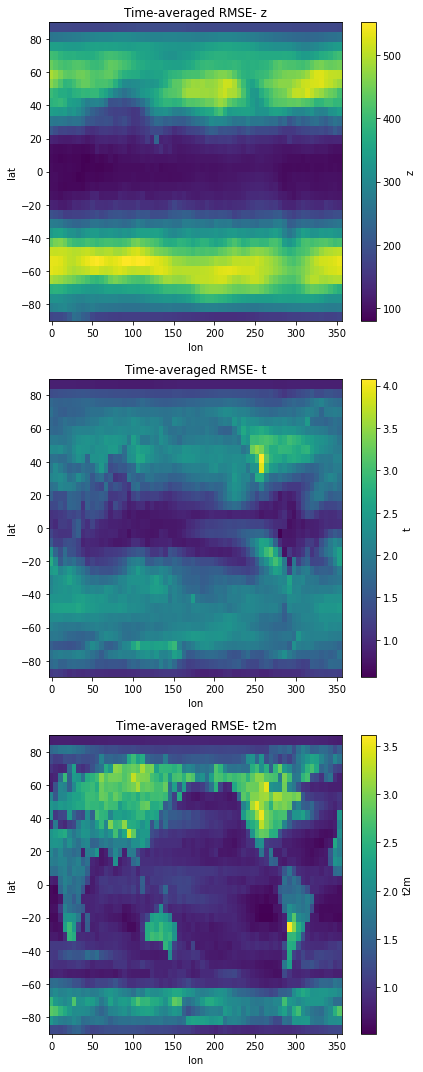

In [43]:
fig, axs = plt.subplots(3, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m']):
    
    param_global_rmse[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged RMSE- {v}')
    plt.savefig(f'{result_dir}/figures/param_global_rmse_{v}.pdf')
fig.tight_layout()

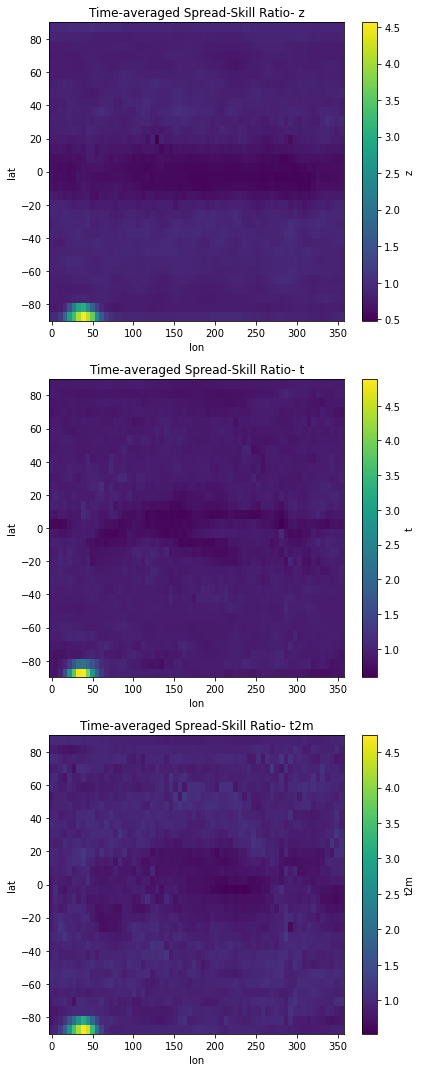

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m']):
    
    param_global_ss[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged Spread-Skill Ratio- {v}')
    plt.savefig(f'{result_dir}/figures/param_global_ss_{v}.pdf')

fig.tight_layout()

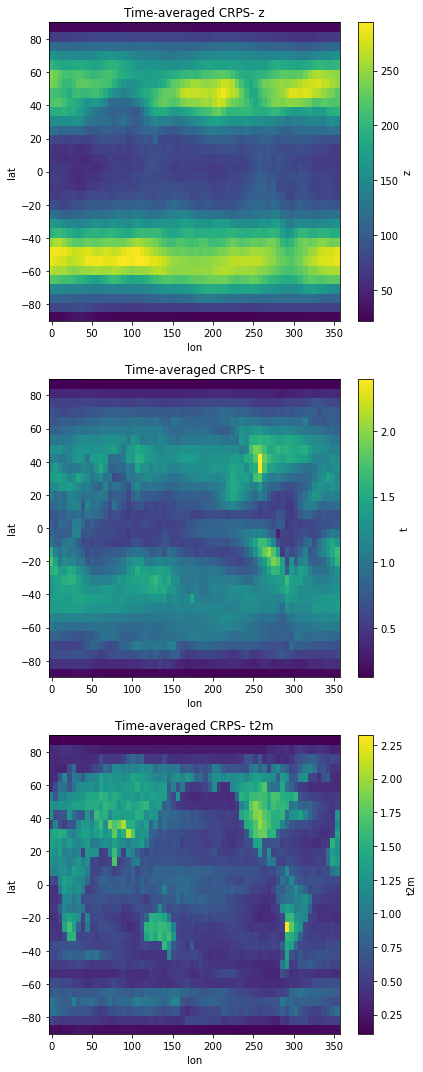

In [45]:
fig, axs = plt.subplots(3, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m']):
    
    param_global_crps[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged CRPS- {v}')
    plt.savefig(f'{result_dir}/figures/param_global_crps_{v}.pdf')


fig.tight_layout()

### Rank histogram

In [ ]:
members

In [ ]:
das = []
for v in preds_ztt_mean:
    da = xr.DataArray(
        np.random.normal(
            preds_ztt_mean[v].values, 
            preds_ztt_std[v].values,
            size=(members, *preds_ztt_mean[v].shape)
        ),
        coords={
            'member': np.arange(members),
            'time': preds_ztt_mean.time,
            'lat': preds_ztt_mean.lat, 
            'lon': preds_ztt_mean.lon,}, 
        dims=['member','time','lat', 'lon'],
        name=v
    )
    das.append(da)
preds_ztt_ens = xr.merge(das)

In [ ]:
preds_ztt_ens.to_netcdf('tmp/preds_param_ztt_ens.nc')

In [ ]:
preds_ztt_ens = xr.open_dataset('tmp/preds_param_ztt_ens.nc')

In [ ]:
ranks = {}
for v in preds_ztt_ens:
    print(v)
    time = preds_ztt_ens.time
    p = preds_ztt_ens[v].sel(time=time)
    o = valid[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
    ranks[v] = rank

In [ ]:
with open(f'tmp/parametric_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Parametric - {v}')

## Categorical

In [55]:
valid_diff = (valid.shift() -  valid.shift(time=lead_time)).isel(time=slice(0, None, 12))

In [56]:
valid_diff['tp'] = valid['tp']

In [57]:
valid_diff

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 1460)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>

In [58]:
valid_diff['tp'] = np.maximum(0, valid_diff.tp)

In [60]:
# 3days
# preds_cat = xr.merge([
#     xr.open_dataset(f'{pred_save_dir}/006.1-resnet_d3_z_3d_cat.nc'),
#     xr.open_dataset(f'{pred_save_dir}/007.1-resnet_d3_t_3d_cat.nc'),
#     xr.open_dataset(f'{pred_save_dir}/008.1-resnet_d3_t2m_3d_cat.nc'),
#     xr.open_dataset(f'{pred_save_dir}/009-resnet_d3_tp_3d_cat.nc'),
# ]).isel(time=slice(0, None, 12))

#5 days
preds_cat = xr.merge([
    xr.open_dataset(f'{pred_save_dir}/028-resnet_d3_z_5d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/029-resnet_d3_t_5d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/030-resnet_d3_t2m_5d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/031-resnet_d3_tp_5d_cat.nc'),
]).isel(time=slice(0, None, 12))

In [61]:
preds_cat

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 1449)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-06T12:00:00 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 ...
    t        (time, lat, lon, bin) float32 ...
    t2m      (time, lat, lon, bin) float32 ...
    tp       (time, lat, lon, bin) float32 ...

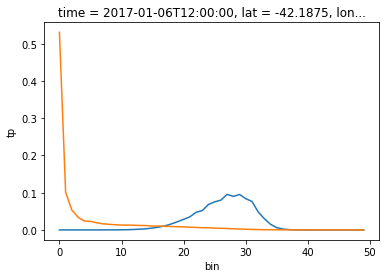

In [63]:
time = '2017-01-04T12:00:00' #3days
time = '2017-01-06T12:00:00' #5days
preds_cat.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat.tp.sel(time=time).isel(lat=8, lon=16).plot()

In [64]:
def log_retrans(x, e):
    return np.exp(x + np.log(e)) - e

In [65]:
# Adjust bin edges and mid_points
for v in ['z', 't', 't2m']:
    preds_cat[v].bin_edges[0] = valid_diff[v].min().values
    preds_cat[v].bin_edges[-1] = valid_diff[v].max().values
    preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2

v='tp'
preds_cat[v].bin_edges[:] = log_retrans(preds_cat[v].bin_edges, 0.001)
preds_cat[v].bin_edges[0] = 0
preds_cat[v].bin_edges[-1] = valid[v].max().values
preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2
preds_cat[v].mid_points[0] = 0

### RMSE of mean

In [66]:
means = []
for v in preds_cat:
    means.append((preds_cat[v] * preds_cat[v].mid_points).sum('bin'))
means = xr.merge(means)

In [67]:
rmse_cat = compute_weighted_rmse(means, valid_diff).load()

In [68]:
rmse_cat

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 617.6
    t        float64 2.788
    t2m      float64 2.154
    tp       float64 0.002317

In [69]:
#rmse_cat.to_netcdf('tmp/categorical_rmse.nc')
#rmse_cat.to_netcdf('../../data/WeatherBench/tmp/5_day/categorical_rmse.nc')

### Spread/skill ratio

In [70]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
meansquares = []
for v in preds_cat:
    meansquares.append((preds_cat[v] * preds_cat[v].mid_points**2).sum('bin'))
meansquares = xr.merge(meansquares)

In [71]:
var = meansquares - means**2

In [72]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [73]:
spread = np.sqrt((var*weights_lat).mean())

In [74]:
spread_skill = spread / rmse_cat

In [75]:
spread_skill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 0.8736
    t        float64 0.8581
    t2m      float64 0.8992
    tp       float64 1.124

In [76]:
#spread_skill.to_netcdf('tmp/categorical_spreadskill.nc')
#spread_skill.to_netcdf('../../data/WeatherBench/tmp/5_day/categorical_spreadskill.nc')

### CRPS

In [77]:
crps = compute_weighted_bin_crps(preds_cat, valid_diff)

100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


In [78]:
crps

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 268.0
    t        float64 1.334
    t2m      float64 0.9097
    tp       float64 0.0005347

In [79]:
#crps.to_netcdf('tmp/categorical_crps.nc')
#crps.to_netcdf('../../data/WeatherBench/tmp/5_day/categorical_crps.nc')

### Global Maps

In [65]:
cat_global_rmse=rmse_global(means, valid_diff)

In [66]:
var = meansquares - means**2
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()
spread = np.sqrt((var*weights_lat).mean('time'))
cat_global_ss = spread / cat_global_rmse

In [67]:
def compute_weighted_bin_crps_global(da_fc, da_true):
    """
    """
    t = np.intersect1d(da_fc.time, da_true.time)
    da_fc, da_true = da_fc.sel(time=t), da_true.sel(time=t)
    weights_lat = np.cos(np.deg2rad(da_true.lat))
    weights_lat /= weights_lat.mean()
    dims = ['time', 'lat', 'lon']
    if type(da_true) is xr.Dataset:
        das = []
        for var in da_true:
            result = compute_bin_crps_da(da_true[var], da_fc[var])
#             result = compute_bin_crps(da_true[var], da_fc[var], da_fc[var].bin_edges)
            das.append(xr.DataArray(
                result, dims=dims, coords=dict(da_true.coords), name=var
            ))
        crps = xr.merge(das)
    else:
#         result = compute_bin_crps(da_true, da_fc, da_fc.bin_edges)
        result = compute_bin_crps_da(da_true, da_fc)
        crps = xr.DataArray(
            result, dims=dims, coords=dict(da_true.coords), name=da_fc.name
        )
    crps = (crps * weights_lat).mean('time')
    return crps

cat_global_crps=compute_weighted_bin_crps_global(preds_cat, valid_diff)

100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


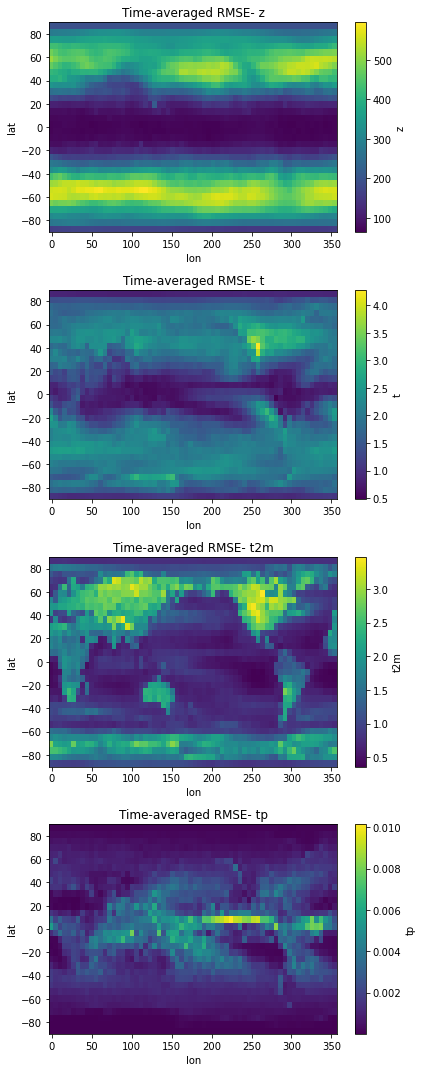

In [68]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    cat_global_rmse[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged RMSE- {v}')
    plt.savefig(f'{result_dir}/figures/cat_global_rmse_{v}.pdf')
fig.tight_layout()

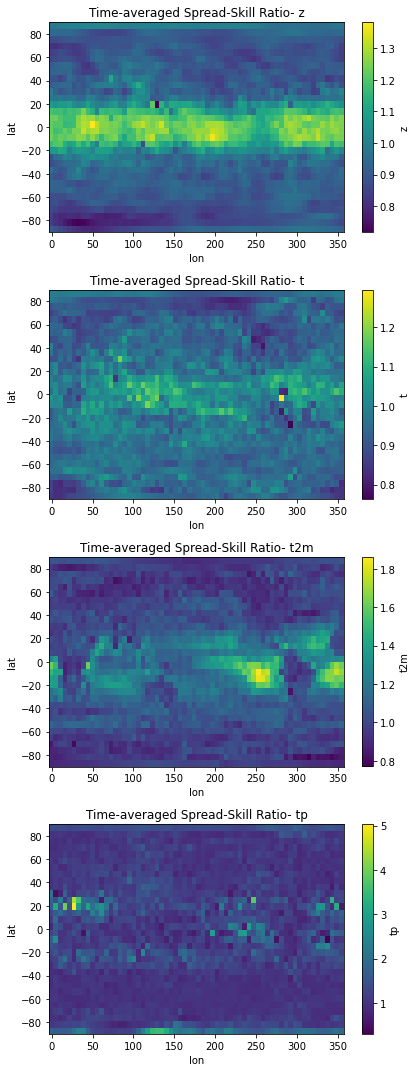

In [69]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    cat_global_ss[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged Spread-Skill Ratio- {v}')
    plt.savefig(f'{result_dir}/figures/cat_global_ss_{v}.pdf')
fig.tight_layout()

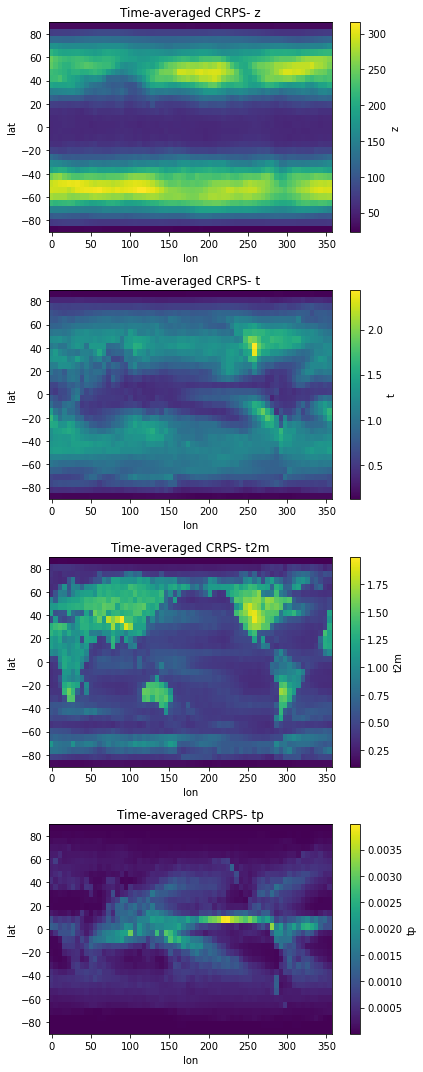

In [70]:
fig, axs = plt.subplots(4, 1, figsize=(6, 15))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    
    cat_global_crps[v].plot(ax=axs[j])
    axs[j].set_title(f'Time-averaged CRPS- {v}')
    plt.savefig(f'{result_dir}/figures/cat_global_crps_{v}.pdf')
fig.tight_layout()

### Rank histogram

In [102]:
time = preds_cat.time

In [103]:
def rand_choice(p, mid_points=None):
    p = p / p.sum()
    return np.random.choice(mid_points, size=1, p=p, replace=True)

In [104]:
das = []
for v in preds_cat:
    da = preds_cat[v].sel(time=time)
    da = xr.concat([xr.apply_ufunc(
        rand_choice, da, kwargs={'mid_points': da.mid_points}, input_core_dims=[['bin']], vectorize=True
    )  for i in range(members)], 'member')
    das.append(da)
preds_cat_ens = xr.merge(das)

KeyboardInterrupt: 

In [ ]:
preds_cat_ens

In [ ]:
#preds_cat_ens.to_netcdf('tmp/preds_cat_ens.nc')
#preds_cat.to_netcdf('../../data/WeatherBench/tmp/5_day/preds_cat_ens.nc')

In [ ]:
ranks = {}
for v in preds_cat_ens:
    print(v)
    time = preds_cat_ens.time
    p = preds_cat_ens[v].sel(time=time)
    o = valid_diff[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
    ranks[v] = rank

In [ ]:
with open(f'tmp/categorical_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

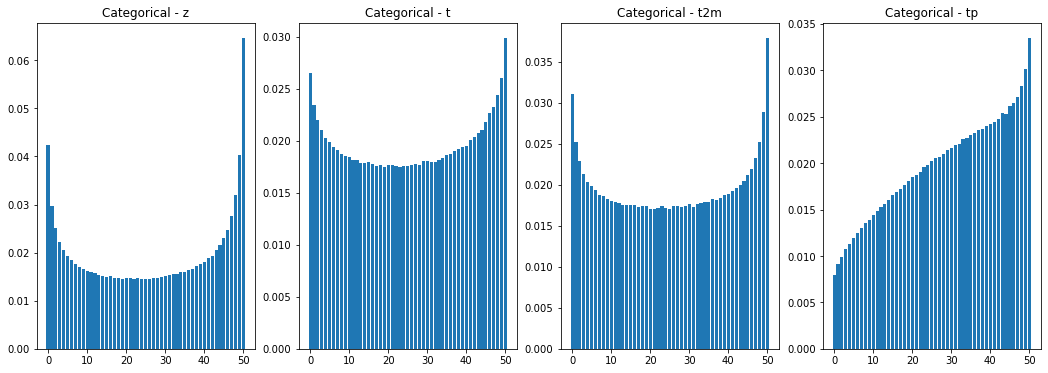

In [221]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Categorical - {v}')

## Quantile-bins categorical

In [ ]:
preds_cat_quant = xr.merge([
    xr.open_dataset(f'{pred_save_dir}/010-resnet_d3_z_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/011-resnet_d3_t_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/012-resnet_d3_t2m_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/013-resnet_d3_tp_3d_cat_quant.nc'),
]).isel(time=slice(0, None, 12))

In [ ]:
preds_cat_quant

In [ ]:
time = '2017-01-04T12:00:00'
preds_cat_quant.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat_quant.tp.sel(time=time).isel(lat=8, lon=16).plot()

In [ ]:
# Adjust bin edges and mid_points
for v in ['z', 't', 't2m', 'tp']:
    preds_cat_quant[v].bin_edges[0] = valid_diff[v].min().values
    preds_cat_quant[v].bin_edges[-1] = valid_diff[v].max().values
    preds_cat_quant[v].mid_points[:] = (preds_cat_quant[v].bin_edges[1:] +  preds_cat_quant[v].bin_edges[:-1])/2

In [ ]:
preds_cat_quant.tp.isel(time=0).plot()

## 5 day testing

Done: 
tigge - rmse, ss, crps.

categorical - rmse, ss, crps.

Rest Remaining

In [90]:
#Tigge
rmse=xr.open_dataset(f'{result_dir}/tigge_rmse.nc')
ss=xr.open_dataset(f'{result_dir}/tigge_spreadskill.nc')
crps=xr.open_dataset(f'{result_dir}/tigge_crps.nc')
rmse.load(), ss.load(), crps.load()

(<xarray.Dataset>
 Dimensions:            ()
 Coordinates:
     isobaricInhPa      int64 500
     heightAboveGround  int64 2
     step               timedelta64[ns] 5 days
     surface            int64 0
 Data variables:
     z                  float64 296.8
     t                  float64 1.725
     t2m                float64 1.567
     tp                 float64 0.004688,
 <xarray.Dataset>
 Dimensions:            ()
 Coordinates:
     step               timedelta64[ns] 5 days
     isobaricInhPa      int64 500
     heightAboveGround  int64 2
     surface            int64 0
 Data variables:
     z                  float64 1.001
     t                  float64 0.957
     t2m                float64 0.7981
     tp                 float64 0.9749,
 <xarray.Dataset>
 Dimensions:            ()
 Coordinates:
     step               timedelta64[ns] 5 days
     isobaricInhPa      int64 500
     heightAboveGround  int64 2
     surface            int64 0
 Data variables:
     z                  fl

In [101]:
#categorical
rmse=xr.open_dataset(f'{result_dir}/categorical_rmse.nc')
ss=xr.open_dataset(f'{result_dir}/categorical_spreadskill.nc')
crps=xr.open_dataset(f'{result_dir}/categorical_crps.nc')
rmse.load(), ss.load(), crps.load()

(<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 617.6
     t        float64 2.788
     t2m      float64 2.154
     tp       float64 0.002317,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 0.8736
     t        float64 0.8581
     t2m      float64 0.8992
     tp       float64 1.124,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 268.0
     t        float64 1.334
     t2m      float64 0.9097
     tp       float64 0.0005347)

In [9]:
args = load_args('../nn_configs/P/027-resnet_d3_ztt_5d_param.yml')

In [11]:
args['model_save_dir']=model_save_dir

In [13]:
pred_save_dir

'/home/garg/data/WeatherBench/predictions_P'

In [15]:
args

{'my_config': '../nn_configs/P/027-resnet_d3_ztt_5d_param.yml',
 'datadir': '/data/stephan/WeatherBench/5.625deg/',
 'exp_id': '027-resnet_d3_ztt_5d_param',
 'model_save_dir': '/home/garg/data/WeatherBench/predictions_P/saved_models',
 'pred_save_dir': '/home/garg/data/WeatherBench/predictions_P',
 'var_dict': {'geopotential': ('z', [50, 250, 500, 600, 700, 850, 925]),
  'temperature': ('t', [50, 250, 500, 600, 700, 850, 925]),
  'u_component_of_wind': ('u', [50, 250, 500, 600, 700, 850, 925]),
  'v_component_of_wind': ('v', [50, 250, 500, 600, 700, 850, 925]),
  'specific_humidity': ('q', [50, 250, 500, 600, 700, 850, 925]),
  'toa_incident_solar_radiation': ('tisr', None),
  '2m_temperature': ('t2m', None),
  '6hr_precipitation': ('tp', None),
  'constants': ['lsm', 'orography', 'lat2d']},
 'output_vars': ['z_500', 't_850', 't2m'],
 'filters': [128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  128,
  6

In [14]:
# Building Predictions

#Parametric
args = load_args('../nn_configs/P/027-resnet_d3_ztt_5d_param.yml')
#Changing directory
args['model_save_dir']=model_save_dir
args['pred_save_dir']=pred_save_dir

args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

dg_test = load_data(**args, only_test=True)



OSError: no files to open

In [ ]:
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'crps_loss': tf.keras.losses.mse})